<a target="_blank" href="https://colab.research.google.com/github/RaphaelMaser/Ray_Tune/blob/main/Ray%20HPO%20hands-on%20solution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
%pip install ray[tune]==2.2.0
%pip install tensorboardx==2.5.1
%pip install matplotlib==3.6.3

In [2]:
import ray
from ray import air, tune
from ray.air import session

# HPO with Ray Tune

The task in this notebook is to use Ray Tune to optimize the hyperparameters, namely "a" and "b", of the function "objective_function" in order to maximize "metric". Possible values for "a" and "b" are in the range from 0 to 1.

In [3]:
def objective_function(a, b):
  for i in range(10):
    metric = a*i + b

## Random Search

Try to use Ray Tune with the random hyperparameter search. For that purpose you need to modify the function so that it is compatible with Ray Tune, e.g. change the input argument (needs to take a dictionary as input) and report the training progress to Ray. Furthermore you need to define a tuner and run it. If the return value is named "results" the training results can be displayed in the following cell.

Hint: Ray automatically uses random search if you do not specify any search algorithm

In [4]:
def objective_function_tune(config):
  a = config["a"]
  b = config["b"]

  for i in range(10):
    metric = a*i + b
    session.report({"metric": metric})

param_space = {
    "a": tune.uniform(0,1),
    "b": tune.uniform(0,1)
}

tuner = tune.Tuner(
    objective_function_tune,
    param_space = param_space,
    tune_config = tune.TuneConfig(
        num_samples = 5,
        metric="metric",
        mode="max",
        )
    )

results = tuner.fit()

2023-01-25 00:00:58,486	INFO worker.py:1538 -- Started a local Ray instance.


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,metric,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_function_tune_f7e4f_00000,2023-01-25_00-01-02,True,,0ce92b29167f461991d7ee738b8a7293,"0_a=0.4371,b=0.9244",raphael-20ujs00k00,10,4.85798,192.168.188.20,447937,0.0573442,0.00341702,0.0573442,1674601262,0,,10,f7e4f_00000,0.00274801
objective_function_tune_f7e4f_00001,2023-01-25_00-01-04,True,,2f3c7fade4644676896de033c746f4c8,"1_a=0.0111,b=0.5869",raphael-20ujs00k00,10,0.687101,192.168.188.20,448017,0.0731134,0.00379753,0.0731134,1674601264,0,,10,f7e4f_00001,0.00540185
objective_function_tune_f7e4f_00002,2023-01-25_00-01-04,True,,e23674a1714144c6a44f2e3565662f10,"2_a=0.2386,b=0.0531",raphael-20ujs00k00,10,2.20097,192.168.188.20,448019,0.0672703,0.00521922,0.0672703,1674601264,0,,10,f7e4f_00002,0.0047853
objective_function_tune_f7e4f_00003,2023-01-25_00-01-04,True,,cd8acccb496b468d9b75663fcaa60d8c,"3_a=0.1018,b=0.5995",raphael-20ujs00k00,10,1.51592,192.168.188.20,448021,0.0687931,0.0104306,0.0687931,1674601264,0,,10,f7e4f_00003,0.00415063
objective_function_tune_f7e4f_00004,2023-01-25_00-01-04,True,,492c21f0b1424e2096e913c67d734cf8,"4_a=0.0286,b=0.9593",raphael-20ujs00k00,10,1.21642,192.168.188.20,448023,0.0510025,0.0045135,0.0510025,1674601264,0,,10,f7e4f_00004,0.007061


2023-01-25 00:01:04,512	INFO tune.py:762 -- Total run time: 4.58 seconds (3.70 seconds for the tuning loop).


{'a': 0.4370595506419941, 'b': 0.9244450810219726}


Text(0, 0.5, 'Mean accuracy')

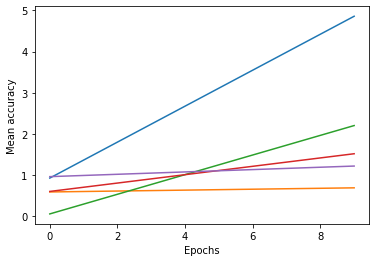

In [5]:
print(results.get_best_result().config)

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.plot(ax=ax, y="metric", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")

## Random Search with ASAH

This time add the ASAH scheduler to the random search.

In [6]:
def objective_function_asah(config):
  a = config["a"]
  b = config["b"]

  for i in range(10):
    metric = a*i + b
    session.report({"metric": metric})

scheduler = tune.schedulers.ASHAScheduler(
    max_t = 10,
    time_attr = "training_iteration",
    grace_period = 3
)

param_space = {
    "a": tune.uniform(0,1),
    "b": tune.uniform(0,1)
}

tuner = tune.Tuner(
    objective_function_asah,
    param_space = param_space,
    tune_config = tune.TuneConfig(
        num_samples = 20,
        metric="metric",
        mode="max",
        scheduler = scheduler,
        )
    )

results_asah = tuner.fit()

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,metric,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_function_asah_fb06e_00000,2023-01-25_00-01-07,True,,a3d70f815c3c4928ac56ada4dcdf1a43,raphael-20ujs00k00,10,8.93282,192.168.188.20,448365,0.972294,0.0482814,0.972294,1674601267,0,,10,fb06e_00000,0.00418258
objective_function_asah_fb06e_00001,2023-01-25_00-01-11,True,,f7d27ce2edc94a73bd2377503e5165c5,raphael-20ujs00k00,3,1.26678,192.168.188.20,448446,0.818475,0.268718,0.818475,1674601271,0,,3,fb06e_00001,0.00548077
objective_function_asah_fb06e_00002,2023-01-25_00-01-11,True,,75571769803344958f8ee2cd64d8621b,raphael-20ujs00k00,10,9.14522,192.168.188.20,448448,0.655627,0.0145235,0.655627,1674601271,0,,10,fb06e_00002,0.0112495
objective_function_asah_fb06e_00003,2023-01-25_00-01-11,True,,e1ce0150cf2c43ba83f9d47ea31852c7,raphael-20ujs00k00,3,0.876422,192.168.188.20,448450,0.695515,0.00583005,0.695515,1674601271,0,,3,fb06e_00003,0.00730014
objective_function_asah_fb06e_00004,2023-01-25_00-01-11,True,,26a7b70fc7d6421e911eea09fb92be07,raphael-20ujs00k00,3,1.48126,192.168.188.20,448452,0.689029,0.66636,0.689029,1674601271,0,,3,fb06e_00004,0.00977492
objective_function_asah_fb06e_00005,2023-01-25_00-01-11,True,,c72252bffde746a3966a4cebee07dd9c,raphael-20ujs00k00,3,2.03482,192.168.188.20,448454,0.30663,0.0691023,0.30663,1674601271,0,,3,fb06e_00005,0.0121415
objective_function_asah_fb06e_00006,2023-01-25_00-01-11,True,,cf595d8f562441b1ba9ef7e50c7f0834,raphael-20ujs00k00,10,6.59555,192.168.188.20,448456,0.992512,0.0040679,0.992512,1674601271,0,,10,fb06e_00006,0.00715137
objective_function_asah_fb06e_00007,2023-01-25_00-01-11,True,,c41d5bb9f31f473c9fefce2a0c316c32,raphael-20ujs00k00,3,1.99624,192.168.188.20,448458,0.665044,0.0642936,0.665044,1674601271,0,,3,fb06e_00007,0.00589299
objective_function_asah_fb06e_00008,2023-01-25_00-01-11,True,,f67a51f6c910446fa21328e0f8b0e70c,raphael-20ujs00k00,10,6.92213,192.168.188.20,448460,0.797923,0.00445938,0.797923,1674601271,0,,10,fb06e_00008,0.00466943
objective_function_asah_fb06e_00009,2023-01-25_00-01-11,True,,46ef1714e6444f4eb17ff1b0ebdb262d,raphael-20ujs00k00,3,0.469209,192.168.188.20,448462,0.329827,0.102531,0.329827,1674601271,0,,3,fb06e_00009,0.00527811


2023-01-25 00:01:12,019	INFO tune.py:762 -- Total run time: 6.83 seconds (6.57 seconds for the tuning loop).


{'a': 0.9254033093605166, 'b': 0.8165877934577149}


Text(0, 0.5, 'Mean accuracy')

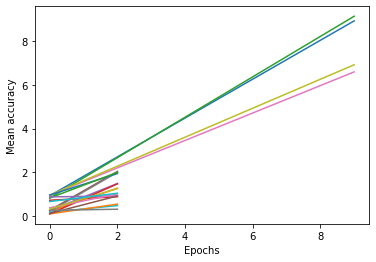

In [7]:
print(results_asah.get_best_result().config)

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results_asah}
for d in dfs.values():
    ax = d.plot(ax=ax, y="metric", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")